## Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('imdb_ts.csv')
df

,id,0,1,2,3,4,5,6,7,8,...,93,94,95,96,97,98,99,rating,genre,rating_category
0,tt0062622,57057.0,65469.0,71642.0,73025.0,74060.0,49472.0,30258.0,28036.0,25824.0,...,10709.0,11042.0,11388.0,11847.0,12404.0,13679.0,15056.0,8.3,"['Adventure', 'Sci-Fi']",High
1,tt0064816,1923.0,2422.0,2853.0,2947.0,3054.0,2844.0,2617.0,1998.0,1277.0,...,637.0,734.0,857.0,785.0,724.0,713.0,699.0,7.1,"['Crime', 'Drama', 'Romance']",High
2,tt0088178,332925.0,302503.0,267264.0,261879.0,256608.0,196530.0,112728.0,117384.0,123024.0,...,6784.0,7253.0,7776.0,9632.0,11212.0,9010.0,6431.0,8.7,"['Documentary', 'Music']",High
3,tt0145487,682857.0,407032.0,78058.0,81732.0,86772.0,83724.0,79940.0,39656.0,6974.0,...,21094.0,10995.0,1586.0,1421.0,1177.0,970.0,802.0,7.4,"['Action', 'Adventure', 'Sci-Fi']",High
4,tt0359950,7813372.0,6274563.0,4781588.0,4655046.0,4535301.0,4650574.0,4758452.0,4069428.0,3471755.0,...,88635.0,68347.0,45367.0,28915.0,15494.0,16155.0,16853.0,7.3,"['Adventure', 'Comedy', 'Drama']",High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,1077363.0,1061148.0,1043451.0,912840.0,738595.0,508118.0,296236.0,318113.0,341113.0,...,2396.0,2425.0,2461.0,2223.0,1920.0,1991.0,2051.0,6.4,"['Horror', 'Mystery', 'Thriller']",Medium
1130,tt9735462,56775.0,57750.0,58828.0,53549.0,48484.0,37340.0,19243.0,30804.0,55897.0,...,739.0,618.0,488.0,636.0,883.0,904.0,920.0,6.3,"['Biography', 'Comedy', 'Drama']",Medium
1131,tt9764362,3595005.0,3401235.0,3221227.0,2645775.0,2188725.0,1681250.0,1030698.0,1138724.0,1290788.0,...,345246.0,257388.0,182883.0,165311.0,144119.0,128009.0,111756.0,7.2,"['Comedy', 'Horror', 'Thriller']",High
1132,tt9784798,528167.0,617409.0,696127.0,741481.0,802782.0,527997.0,177249.0,141753.0,100026.0,...,10108.0,10511.0,10878.0,7491.0,3752.0,5237.0,6592.0,7.4,"['Biography', 'Drama', 'History']",High


#some suggestion to add
1) maybe adding the log transformation to reduce skewness -{copy chiara preprocessing steps}
2) scaling the data using StandardScaler
3) First 50 time steps for clustering
4) add PCA

In [3]:
# Prepare the data
time_series_data = df.iloc[:,1:101].values
time_series_data = np.log1p(time_series_data)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(time_series_data.T).T # Chiara's suggestion: z-score per serie

In [4]:
def paa_transform(series_matrix, M): 
    """ Apply PAA to each time series. series_matrix: shape (n_samples, T) M: number of segments """ 
    n, T = series_matrix.shape 
    segment_size = T // M 
    paa_output = np.zeros((n, M)) 
    for i in range(n): 
        for m in range(M): 
            start = m * segment_size 
            end = (m + 1) * segment_size 
            paa_output[i, m] = np.mean(series_matrix[i, start:end]) 
            return paa_output 
        # Apply PAA 
M = 20 
print(f"Applying PAA with M={M} segments...") 
paa_data = paa_transform(scaled_data, M=M) 
print("PAA shape:", paa_data.shape)

Applying PAA with M=20 segments...
PAA shape: (1134, 20)


## Dynamic Time Warping

CPU times: total: 3min 29s
Wall time: 4min 2s


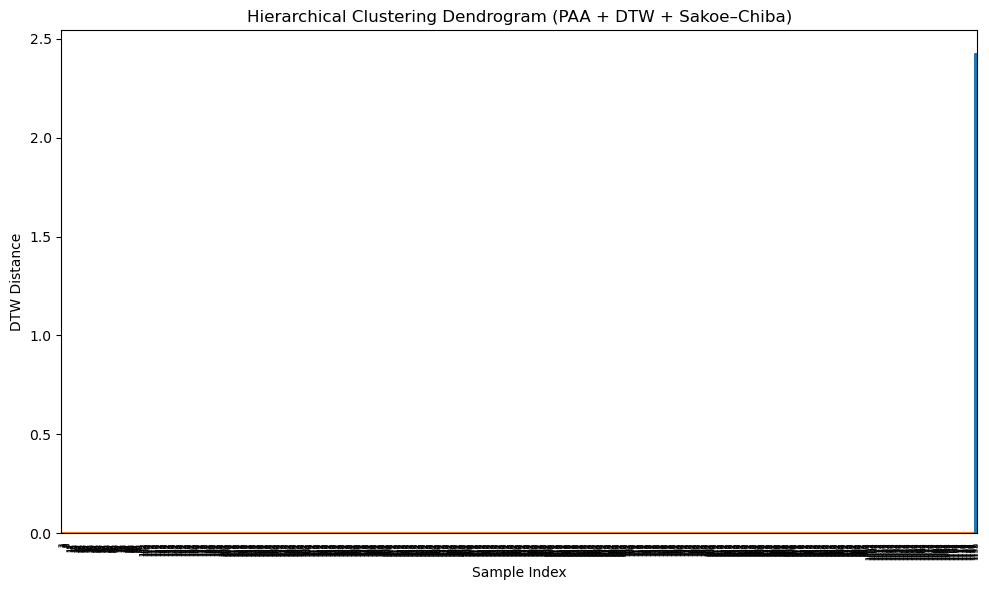

In [6]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from tslearn.metrics import cdist_dtw

# -------------------------------------------------------
# 1. Compute DTW distance matrix with Sakoe–Chiba band
# -------------------------------------------------------

band_width = 2   # 10% of 100 days

dtw_dist_matrix = cdist_dtw(
    paa_data,
    global_constraint="sakoe_chiba",
    sakoe_chiba_radius=band_width
)

# Convert full matrix → condensed vector
condensed_dtw = squareform(dtw_dist_matrix)

# -------------------------------------------------------
# 2. Perform hierarchical clustering using DTW distances
# -------------------------------------------------------

linked = linkage(condensed_dtw, method='average')

# -------------------------------------------------------
# 3. Plot dendrogram
# -------------------------------------------------------

plt.figure(figsize=(10, 6))
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title('Hierarchical Clustering Dendrogram (PAA + DTW + Sakoe–Chiba)')
plt.xlabel('Sample Index')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.savefig('dendrogram_dtw.png')

# -------------------------------------------------------
# 4. Assign clusters (example: 4 clusters)
# -------------------------------------------------------

cluster_labels = fcluster(linked, t=4, criterion='maxclust')


In [7]:
M = 40 
print(f"Applying PAA with M={M} segments...") 
paa_data = paa_transform(scaled_data, M=M) 
print("PAA shape:", paa_data.shape)

Applying PAA with M=40 segments...
PAA shape: (1134, 40)


CPU times: total: 5min 32s
Wall time: 7min 41s


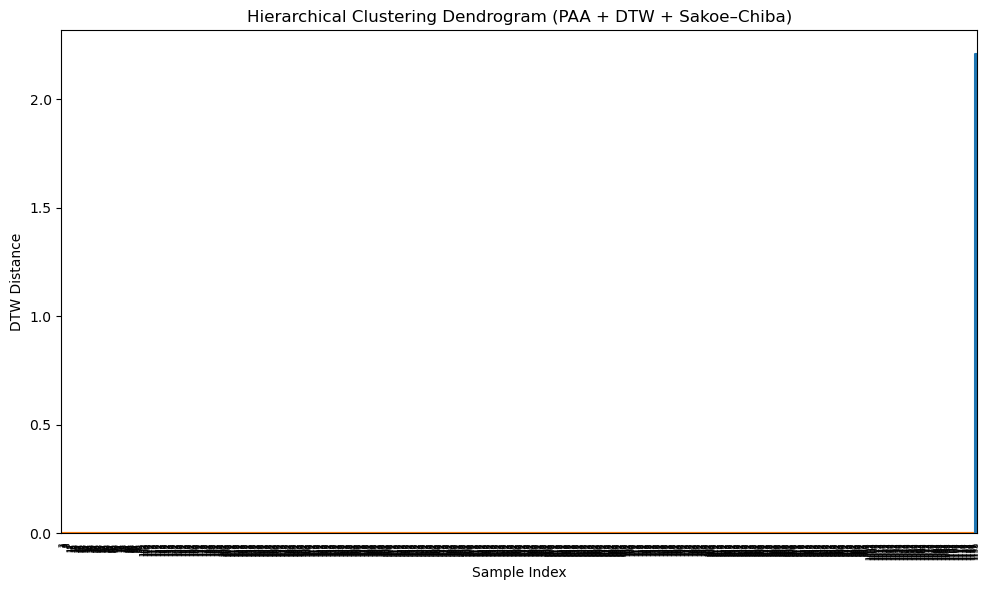

In [9]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from tslearn.metrics import cdist_dtw

# -------------------------------------------------------
# 1. Compute DTW distance matrix with Sakoe–Chiba band
# -------------------------------------------------------

band_width = 4   # 10% of 

dtw_dist_matrix = cdist_dtw(
    paa_data,
    global_constraint="sakoe_chiba",
    sakoe_chiba_radius=band_width
)

# Convert full matrix → condensed vector
condensed_dtw = squareform(dtw_dist_matrix)

# -------------------------------------------------------
# 2. Perform hierarchical clustering using DTW distances
# -------------------------------------------------------

linked = linkage(condensed_dtw, method='average')

# -------------------------------------------------------
# 3. Plot dendrogram
# -------------------------------------------------------

plt.figure(figsize=(10, 6))
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title('Hierarchical Clustering Dendrogram (PAA + DTW + Sakoe–Chiba)')
plt.xlabel('Sample Index')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.savefig('dendrogram_dtw.png')

# -------------------------------------------------------
# 4. Assign clusters (example: 4 clusters)
# -------------------------------------------------------

cluster_labels = fcluster(linked, t=4, criterion='maxclust')


In [10]:
M = 60 
print(f"Applying PAA with M={M} segments...") 
paa_data = paa_transform(scaled_data, M=M) 
print("PAA shape:", paa_data.shape)

Applying PAA with M=60 segments...
PAA shape: (1134, 60)


CPU times: total: 7min 13s
Wall time: 8min 22s


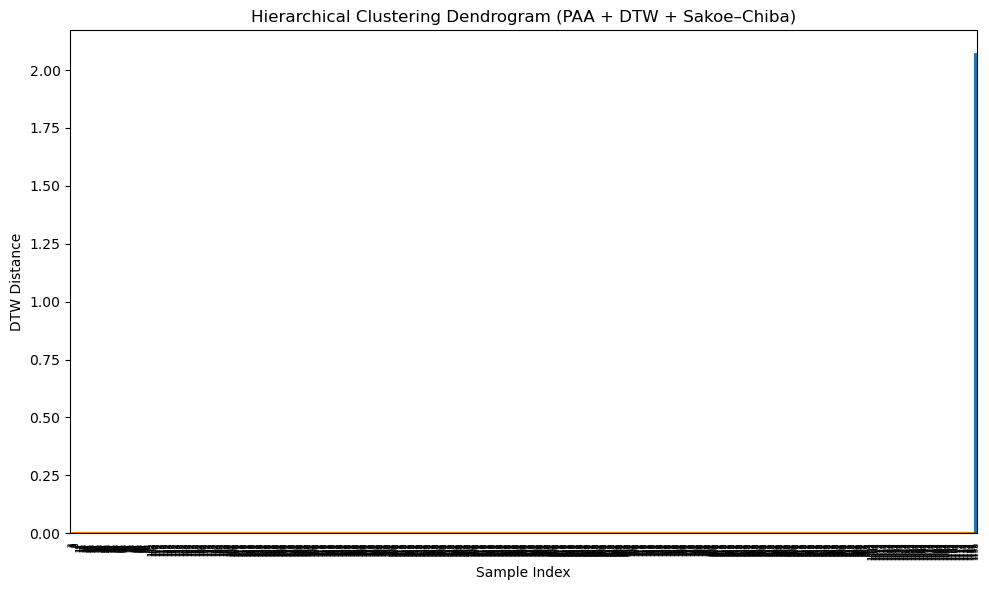

In [11]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from tslearn.metrics import cdist_dtw

# -------------------------------------------------------
# 1. Compute DTW distance matrix with Sakoe–Chiba band
# -------------------------------------------------------

band_width = 6  # 10% of 

dtw_dist_matrix = cdist_dtw(
    paa_data,
    global_constraint="sakoe_chiba",
    sakoe_chiba_radius=band_width
)

# Convert full matrix → condensed vector
condensed_dtw = squareform(dtw_dist_matrix)

# -------------------------------------------------------
# 2. Perform hierarchical clustering using DTW distances
# -------------------------------------------------------

linked = linkage(condensed_dtw, method='average')

# -------------------------------------------------------
# 3. Plot dendrogram
# -------------------------------------------------------

plt.figure(figsize=(10, 6))
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title('Hierarchical Clustering Dendrogram (PAA + DTW + Sakoe–Chiba)')
plt.xlabel('Sample Index')
plt.ylabel('DTW Distance')
plt.tight_layout()
plt.savefig('dendrogram_dtw.png')

# -------------------------------------------------------
# 4. Assign clusters (example: 4 clusters)
# -------------------------------------------------------

cluster_labels = fcluster(linked, t=4, criterion='maxclust')


<Figure size 1000x600 with 0 Axes>

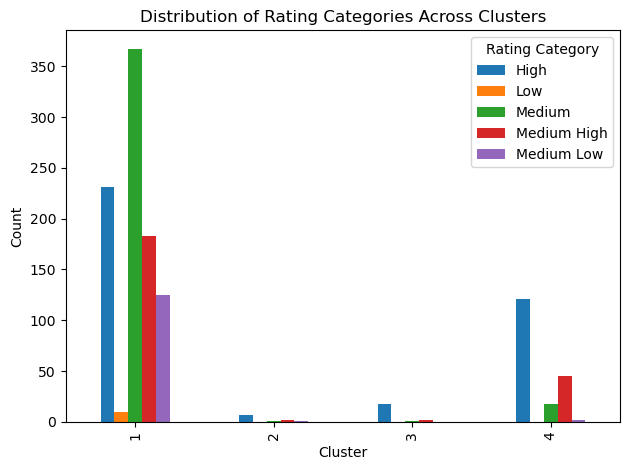

In [5]:
# Add cluster labels to the original dataframe
df['cluster_4'] = cluster_labels

# Compute distribution of rating labels within each cluster
distribution = df.groupby(['cluster_4', 'rating_category']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', stacked=False)
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.tight_layout()
plt.savefig('rating_distribution_by_cluster.png')

In [6]:
# value counts of cluster labels
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)
# Show the distribution table
print(distribution)

Cluster distribution: {1: 916, 2: 11, 3: 21, 4: 186}
rating_category  High  Low  Medium  Medium High  Medium Low
cluster_4                                                  
1                 231   10     367          183         125
2                   7    0       1            2           1
3                  18    0       1            2           0
4                 121    0      18           45           2


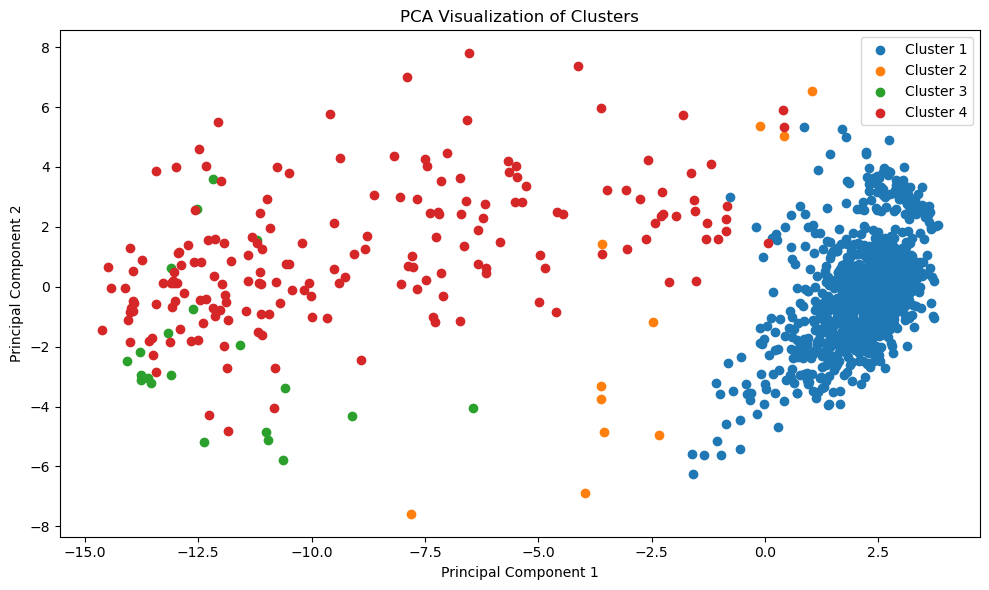

In [7]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

# Plot PCA results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_results[cluster_labels == cluster, 0],
                pca_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('pca_clusters.png')

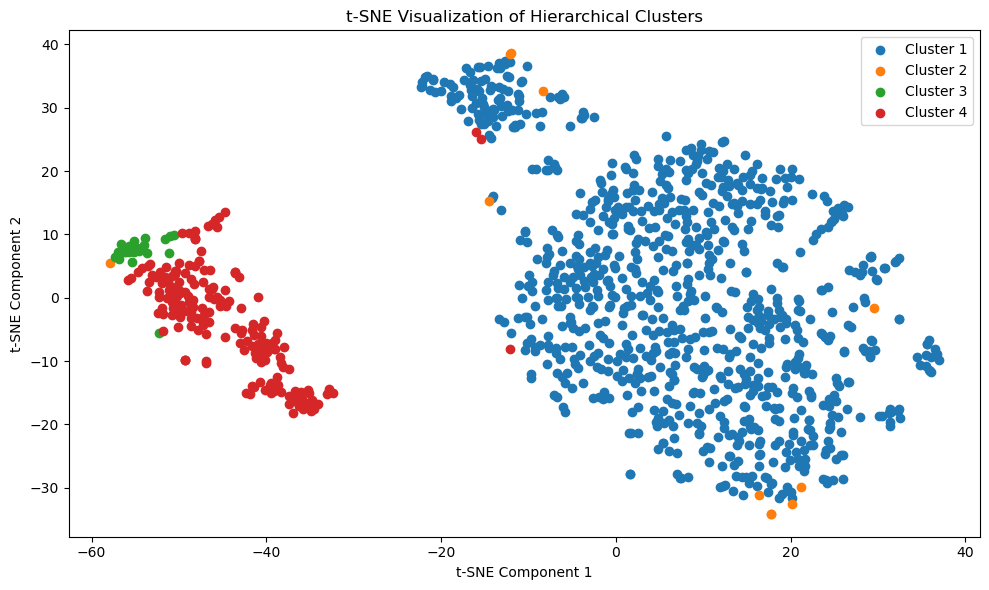

In [8]:

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_data)

# Plot t-SNE results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(tsne_results[cluster_labels == cluster, 0],
                tsne_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('tsne_hierarchical_clusters.png')

## Cluster = 3

In [9]:
# Assign clusters (e.g., 3 clusters)
cluster_labels = fcluster(linked, t=3, criterion='maxclust')

<Figure size 1000x600 with 0 Axes>

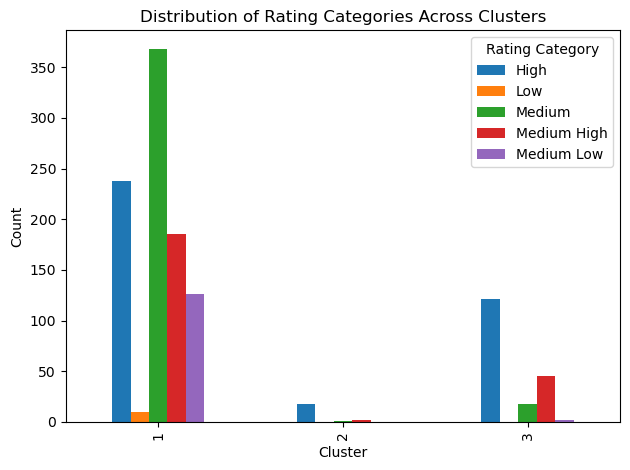

In [10]:
# Add cluster labels to the original dataframe
df['cluster_3'] = cluster_labels

# Compute distribution of rating labels within each cluster
distribution = df.groupby(['cluster_3', 'rating_category']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', stacked=False)
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.tight_layout()
plt.savefig('rating_distribution_by_cluster.png')

In [11]:
# value counts of cluster labels
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)

Cluster distribution: {1: 927, 2: 21, 3: 186}


In [12]:
# Show the distribution table
print(distribution)

rating_category  High  Low  Medium  Medium High  Medium Low
cluster_3                                                  
1                 238   10     368          185         126
2                  18    0       1            2           0
3                 121    0      18           45           2


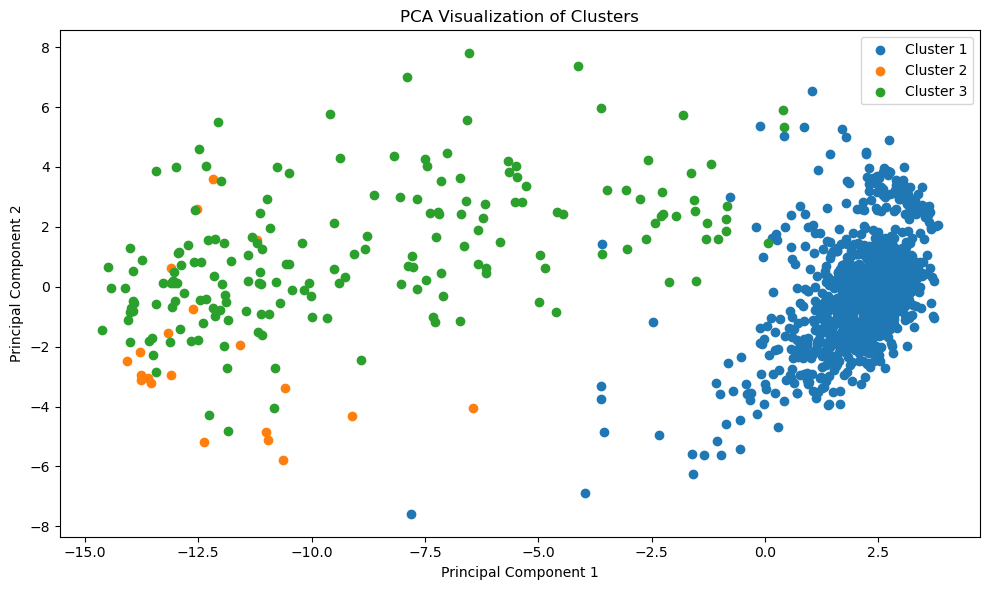

In [13]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

# Plot PCA results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_results[cluster_labels == cluster, 0],
                pca_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('pca_clusters.png')

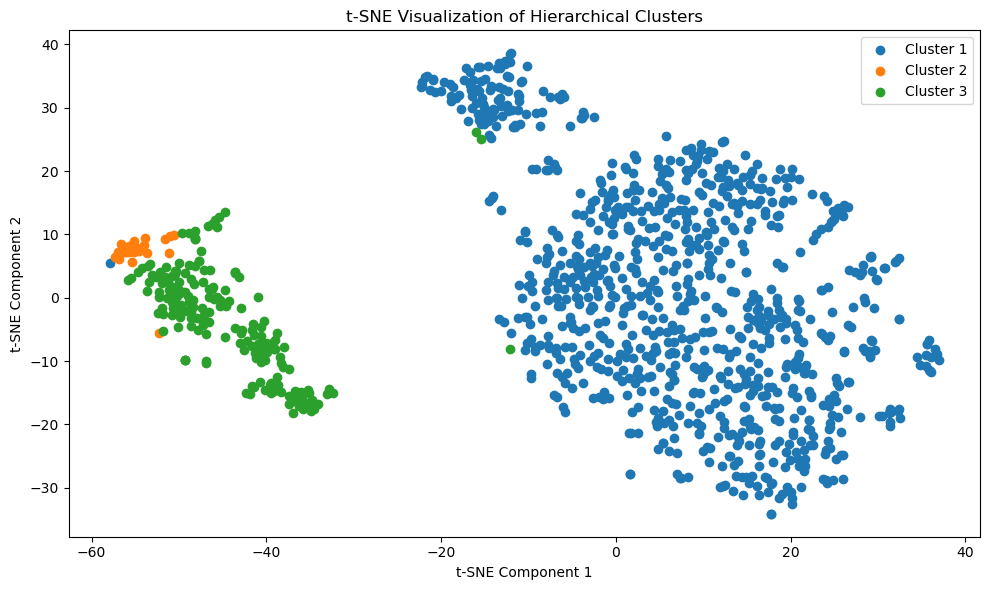

In [14]:

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_data)

# Plot t-SNE results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(tsne_results[cluster_labels == cluster, 0],
                tsne_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('tsne_hierarchical_clusters.png')

## Cluster = 5

In [15]:
# Assign clusters (e.g., 6 clusters)
cluster_labels = fcluster(linked, t=5, criterion='maxclust')

<Figure size 1000x600 with 0 Axes>

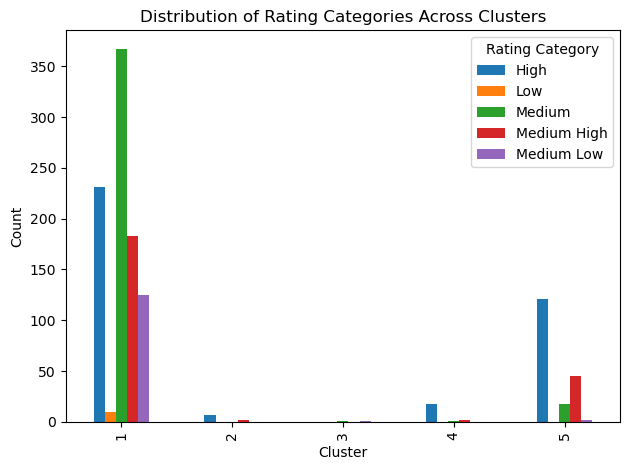

In [16]:
# Add cluster labels to the original dataframe
df['cluster_5'] = cluster_labels

# Compute distribution of rating labels within each cluster
distribution = df.groupby(['cluster_5', 'rating_category']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', stacked=False)
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.tight_layout()
plt.savefig('rating_distribution_by_cluster.png')

In [17]:
# value counts of cluster labels
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)
# Show the distribution table
print(distribution)

Cluster distribution: {1: 916, 2: 9, 3: 2, 4: 21, 5: 186}
rating_category  High  Low  Medium  Medium High  Medium Low
cluster_5                                                  
1                 231   10     367          183         125
2                   7    0       0            2           0
3                   0    0       1            0           1
4                  18    0       1            2           0
5                 121    0      18           45           2


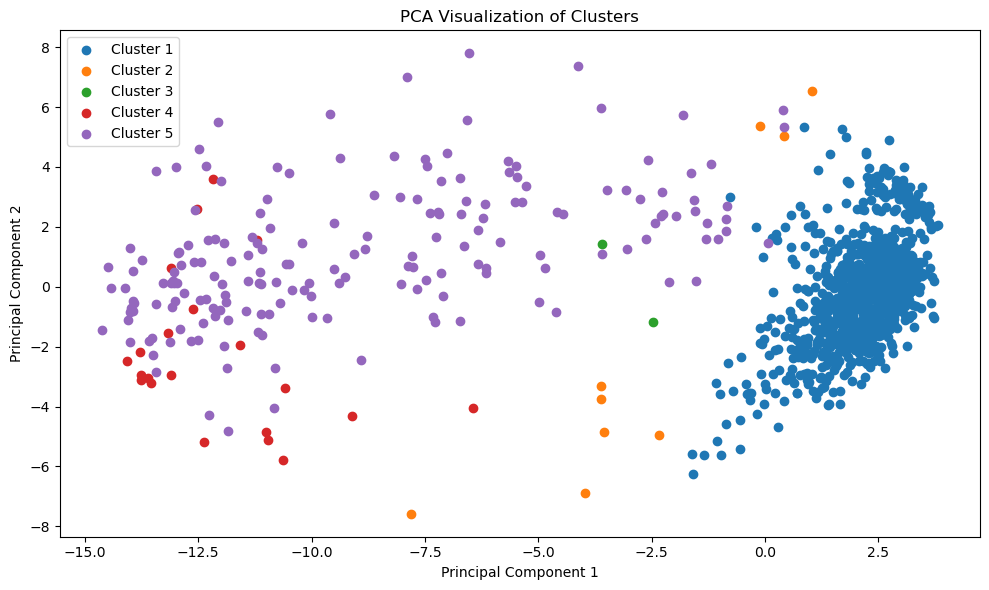

In [18]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

# Plot PCA results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_results[cluster_labels == cluster, 0],
                pca_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('pca_clusters.png')

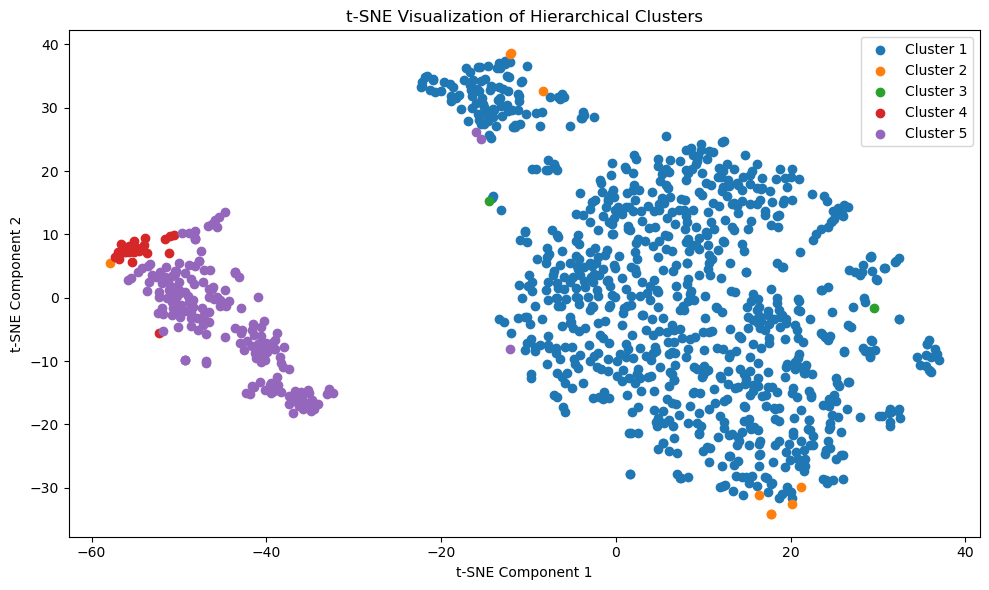

In [19]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_data)

# Plot t-SNE results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(tsne_results[cluster_labels == cluster, 0],
                tsne_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('tsne_hierarchical_clusters.png')

## Cluster = 8

In [20]:
# Assign clusters (e.g., 8 clusters)
cluster_labels = fcluster(linked, t=8, criterion='maxclust')

<Figure size 1000x600 with 0 Axes>

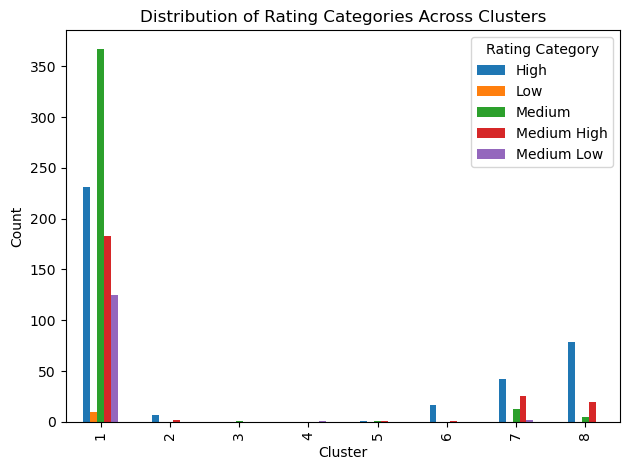

In [21]:
# Add cluster labels to the original dataframe
df['cluster_8'] = cluster_labels

# Compute distribution of rating labels within each cluster
distribution = df.groupby(['cluster_8', 'rating_category']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', stacked=False)
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.tight_layout()
plt.savefig('rating_distribution_by_cluster.png')

In [22]:
# value counts of cluster labels
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)
# Show the distribution table
print(distribution)

Cluster distribution: {1: 916, 2: 9, 3: 1, 4: 1, 5: 3, 6: 18, 7: 82, 8: 104}
rating_category  High  Low  Medium  Medium High  Medium Low
cluster_8                                                  
1                 231   10     367          183         125
2                   7    0       0            2           0
3                   0    0       1            0           0
4                   0    0       0            0           1
5                   1    0       1            1           0
6                  17    0       0            1           0
7                  42    0      13           25           2
8                  79    0       5           20           0


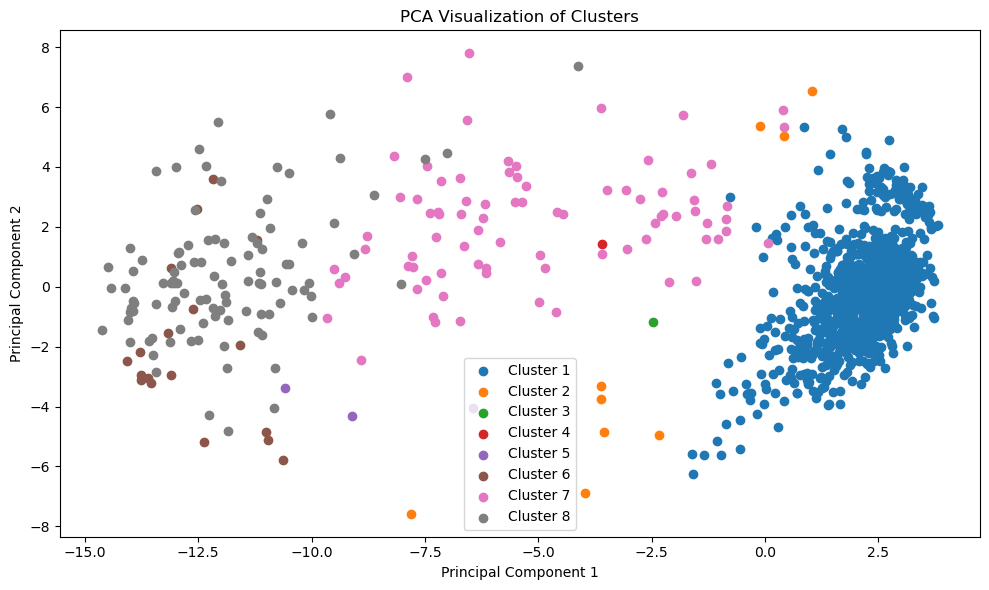

In [23]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

# Plot PCA results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_results[cluster_labels == cluster, 0],
                pca_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('pca_clusters.png')

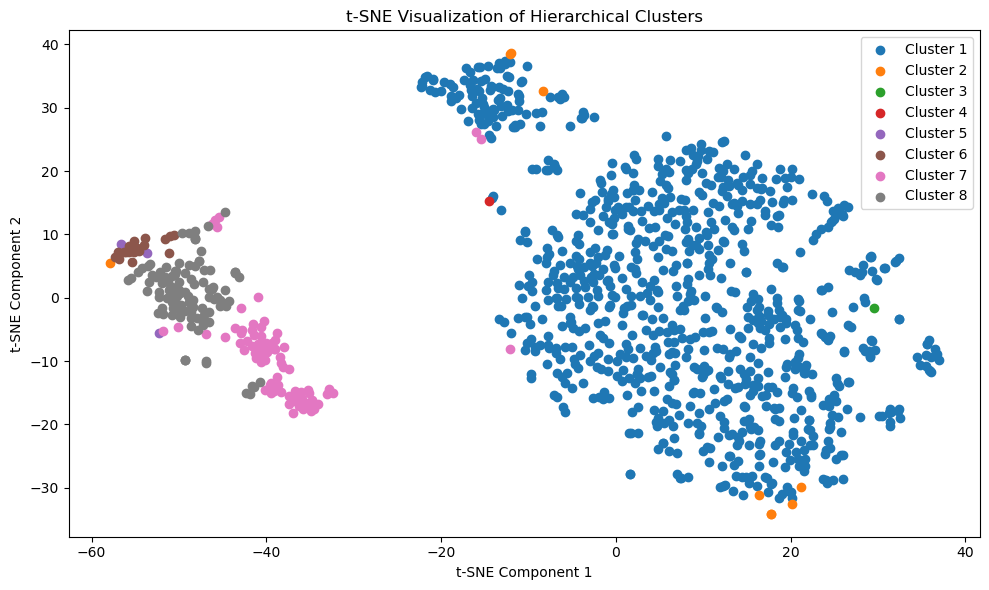

In [24]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_data)

# Plot t-SNE results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(tsne_results[cluster_labels == cluster, 0],
                tsne_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('tsne_hierarchical_clusters.png')